## Programming Exercise 4: Neural Networks Learning

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import scipy.optimize #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function

### 1 Neural Networks

#### 1.1 Visualizing the data

In [27]:
ar = np.array([0,1,0,2,3,1])
print ar
print np.unique(ar)
am = ar.reshape(2,3)
print am
print np.unique(am)
print np.unique(am).shape
print type(np.unique(am))


[0 1 0 2 3 1]
[0 1 2 3]
[[0 1 0]
 [2 3 1]]
[0 1 2 3]
(4,)
<type 'numpy.ndarray'>


In [28]:
#Note this is actually a symlink... same data as last exercise,
#so there's no reason to add another 7MB to my github repo...
datafile = 'data/ex4data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
print "'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y']))
print "'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape)
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [29]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height) #row[1:] to trim out that leading x
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

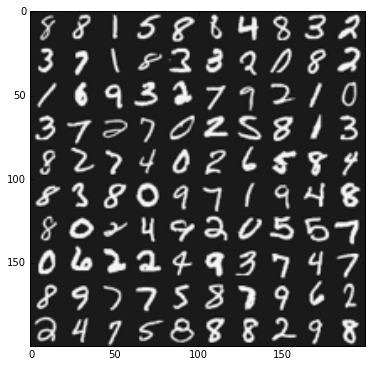

In [30]:
displayData()

#### 1.2 Model representation

In [31]:
#You have been provided with a set of network parameters (Θ(1),Θ(2)) 
#already trained by us. These are stored in ex4weights.mat
datafile = 'data/ex4weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
# The matrices Theta1 and Theta2 will now be in your workspace
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26

In [32]:
# These are some global variables I'm using to ensure the sizes
# of various matrices are correct
#these are NOT including bias units
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]

In [33]:
test = [0,1,2]
flattened_list = [am.flatten() for h in test]
print flattened_list
print type(flattened_list)
combined = list(itertools.chain.from_iterable(flattened_list))
print combined
print type(combined)

[array([0, 1, 0, 2, 3, 1]), array([0, 1, 0, 2, 3, 1]), array([0, 1, 0, 2, 3, 1])]
<type 'list'>
[0, 1, 0, 2, 3, 1, 0, 1, 0, 2, 3, 1, 0, 1, 0, 2, 3, 1]
<type 'list'>


Here I'm just playing with the optimization function again. It makes sense with one variable.

In [34]:
help(scipy.optimize.fmin_cg)

Help on function fmin_cg in module scipy.optimize.optimize:

fmin_cg(f, x0, fprime=None, args=(), gtol=1e-05, norm=inf, epsilon=1.4901161193847656e-08, maxiter=None, full_output=0, disp=1, retall=0, callback=None)
    Minimize a function using a nonlinear conjugate gradient algorithm.
    
    Parameters
    ----------
    f : callable, ``f(x, *args)``
        Objective function to be minimized.  Here `x` must be a 1-D array of
        the variables that are to be changed in the search for a minimum, and
        `args` are the other (fixed) parameters of `f`.
    x0 : ndarray
        A user-supplied initial estimate of `xopt`, the optimal value of `x`.
        It must be a 1-D array of values.
    fprime : callable, ``fprime(x, *args)``, optional
        A function that returns the gradient of `f` at `x`. Here `x` and `args`
        are as described above for `f`. The returned value must be a 1-D array.
        Defaults to None, in which case the gradient is approximated
        numeri

This works great! When I added a second variable, it was throwing errors even when the structure seemed right. The catch is that, as it says all over this exercise, the f & fprime functions can only take 1 argument. Hence the step in these functions to decompose x into u, v for the multiple variables. x0 needs to have the same dimensions as well.

In [35]:
def ftest(x):
    u, v = x
    return u**2 + u*3-2 + v**2

'''print ftest(-1.5,0)
print ftest(-1.6,0)
print ftest(-1.4,0)
'''

def fp(x):
    u, v = x
    return np.array((2*u + 3,2*v))

x0t = np.array((0,0))
print x0t

testRes = scipy.optimize.fmin_cg(ftest, x0t, fprime=fp, full_output=True)

print testRes[0]

[0 0]
Optimization terminated successfully.
         Current function value: -4.250000
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
[-1.49999999  0.        ]


In [36]:
#Some utility functions. There are lot of flattening and
#reshaping of theta matrices, the input X matrix, etc...
#Nicely shaped matrices make the linear algebra easier when developing,
#but the minimization routine (fmin_cg) requires that all inputs
#be vectors

def flattenParams(thetas_list):
    """
    Hand this function a list of theta matrices, and it will flatten it
    into one long (n,1) shaped numpy array
    """
    #flatten() is a built in np function that returns a 1d array
    #Then the list expansion returns a list of those arrays
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]

    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [ theta1, theta2 ]

def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

#### 1.3 Feedforward and cost function

In [37]:
print Theta1.shape
print Theta2.shape

(25, 401)
(10, 26)


In [38]:
def computeCost(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    """
    This function takes in:
        1) a flattened vector of theta parameters (each theta would go from one
           NN layer to the next), the thetas include the bias unit.
        2) the flattened training set matrix X, which contains the bias unit first column
        3) the label vector y, which has one column
    It loops over training points (recommended by the professor, as the linear
    algebra version is "quite complicated") and:
        1) constructs a new "y" vector, with 10 rows and 1 column, 
            with one non-zero entry corresponding to that iteration
        2) computes the cost given that y- vector and that training point
        3) accumulates all of the costs
        4) computes a regularization term (after the loop over training points)
    """
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)
    
    #This is what will accumulate the total cost
    total_cost = 0.
    
    m = n_training_samples

    # Loop over the training points (rows in myX, already contain bias unit)
    for irow in xrange(m):
        myrow = myX[irow]
                
        # First compute the hypothesis (this is a (10,1) vector
        # of the hypothesis for each possible y-value)
        # propagateForward returns (zs, activations) for each layer
        # so propagateforward[-1][1] means "activation for -1st (last) layer"
        myhs = propagateForward(myrow,mythetas)
        #Mike tweaked these steps so you can see sample output of propagateForward:
        #if irow == 0: print myhs
        myhs = myhs[-1][1]

        # Construct a 10x1 "y" vector with all zeros and only one "1" entry
        # note here if the hand-written digit is "0", then that corresponds
        # to a y- vector with 1 in the 10th spot (different from what the
        # homework suggests)
        #Mike: Instantiate as just a vector of 0s
        tmpy  = np.zeros((10,1))
        #Mike: Find the right label's index from the y integer and replace that
        #with 1
        tmpy[myy[irow]-1] = 1
        
        # Compute the cost for this point and y-vector
        '''
        Mike - after all that, computing the cost for this row isn't that complex.
        I hadn't put it together previously that the cost is evaluated just at the
        output layer. The double sum is over k classes & m training samples. It doesn't
        matter what the values or # layers inside the network are.
        In the backprop step, this overall cost is allocated to nodes in each layer, 
        but that doesn't change the total cost.
        This next line is just the vectorized double sum of the usual logistic cost
        over the output nodes. It's summed up by iterating over each training example.
        '''
        mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
     
        # Accumulate the total cost
        total_cost += mycost
  
    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m
    
    # Compute the regularization term
    total_reg = 0.
    for mytheta in mythetas:
        total_reg += np.sum(mytheta*mytheta) #element-wise multiplication
    total_reg *= float(mylambda)/(2*m)
        
    return total_cost + total_reg
       

def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas (NOT flattened), propagates the
    row of features forwards, assuming the features ALREADY
    include the bias unit in the input layer, and the 
    Thetas also include the bias unit

    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element is a tuple of (zs, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    ***The 'activations' are the same as "h", but this works for many layers
    (hence a vector of thetas, not just one theta)
    Also, "h" is vectorized to do all rows at once...
    this function takes in one row at a time***
    """
    
    '''
    Mike's notes:
    It took me a while to piece this together, but it's a nice loop below that 
    propagates through any number of layers thusly:
    
    1 - the overall function takes a single row of xs, so this needs to be run 
    for every row in a loop (as the above computeCost does)
    2 - loop through the layers of the ANN. Thetas is a simple list where each
    element is a matrix of weights for each node. So it breaks down like this:
     - list of Thetas s/t len(Thetas) == # calculation layers in the network
       So this is a 1 hidden, 1 output network. len(Thetas) == 2
     - Each Theta matrix is sized for the layer
       - For hidden layer with 25 nodes & 400 inputs + bias -> 25, 401
       - For output layer with 10 nodes & 25 inputs (ie the previous layer) + bias
         -> 26, 10
       - Each row within theta is the coefficient applied to the input value at that 
         node which all get summed up (dot product)
    3 - Again, row-wise from the training set, calculate z & a for the current layer.
        - This is just 1 step for z as the dot product collapses all those coefficients
          and the vector of Theta lets you do the whole vector of z calculations (25 in 
          hidden, 10 in output) in a single step to return a vector
        - Likewise, just run expit on the vector z to return the a vector
    4 - Store those z & a values in a list for just this row
    5 - The clever escape:
        - If you're on the last Theta, you're done, so convert that
          list of z, a into an array and return it
        - If you're not on the last Theta, add the new bias unit and feed those features
          a into the next iteration (next layer) as the input
    '''
    features = row
    zs_as_per_layer = []
    for i in xrange(len(Thetas)):  
        Theta = Thetas[i]
        #Mike: these comments below are a little misleading as they are only
        #true when this loop is on the hidden layer. But the features = a step 
        #at the bottom lets you loop through any # of layers for which you have Thetas
        #Theta is (25,401), features are (401, 1)
        #so "z" comes out to be (25, 1)
        #this is one "z" value for each unit in the hidden layer
        #not counting the bias unit
        z = Theta.dot(features).reshape((Theta.shape[0],1))
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        if i == len(Thetas)-1:
            return np.array(zs_as_per_layer)
        a = np.insert(a,0,1) #Add the bias unit
        features = a

In [39]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#you should see that the cost is about 0.287629
myThetas = [ Theta1, Theta2 ]

#Note I flatten the thetas vector before handing it to the computeCost routine,
#as per the input format of the computeCost function.
#It does the unrolling/reshaping itself
#I also flatten the X vector, similarly
print computeCost(flattenParams(myThetas),flattenX(X),y)

0.287629165161


#### 1.4 Regularized cost function

In [40]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#and lambda = 1, you should see that the cost is about 0.383770
myThetas = [ Theta1, Theta2 ]
print computeCost(flattenParams(myThetas),flattenX(X),y,mylambda=1.)

0.384487796243


### 2 Backpropagation

#### 2.1 Sigmoid gradient

In [41]:
#This is just the derivative of the sigmoid function
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

print sigmoidGradient(0)

0.25


#### 2.2 Random initialization

In [42]:
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

#### 2.3 Backpropagation


In [43]:
def backPropagate(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)

    #Note: the Delta matrices should include the bias unit
    #The Delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))

    # Loop over the training points (rows in myX, already contain bias unit)
    """
    This is reasonably simple. Just loop through the training examples ->
    propagate forward with the thetas (randomly chosen on the first pass) ->
    calculate the cost for output simply by subtracting 0 or 1 from a3 & 
    calculate the cost for the hidden layer with that sigmoid gradient -> 
    Add them up & divide by m
    
    I do not understand why delta2 is calculated according to the sigmoidGradient
    except that it weights the extent to which that particular unit was responsible
    for the larger error in output layer.
    """
    m = n_training_samples
    for irow in xrange(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size+1,1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        # The way this is structured with hard-coded slices below is, of course, on;y
        # applicable to a 3 layer network. One could have gotten fancier with the way those
        # are stored & called, likely using a dict, to make it robust to other structures.
        temp = propagateForward(myrow,mythetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        delta3 = a3 - tmpy 
        delta2 = mythetas[1].T[1:,:].dot(delta3)*sigmoidGradient(z2) #remove 0th element
        a2 = np.insert(a2,0,1,axis=0)
        #Just to show that these are just the costs at each node
        #if irow == 0:
        #    print "delta3: ", delta3
        #    print "delta2: ", delta2

        #This is the magic step somehow that turns the costs into a single gradient
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        #These are vectors that represent the point gradient in hyperspace
        #To run the actual optimization, fmin_cg requires they be flattened completely
        #(done in the final line of this function) and this is how it runs gradient
        #descent. It really just follows the minimization path from this gradient.
        #The hyperspace in which it descends must be 35-d from the 25 weights in hidden
        #and the 10 weights in output.
        #if irow == 0:
                #print "Delta1: ", Delta1
                #print "Delta2: ", Delta2
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:,1:] = D1[:,1:] + (float(mylambda)/m)*mythetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(mylambda)/m)*mythetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

In [44]:
#Actually compute D matrices for the Thetas provided
flattenedD1D2 = backPropagate(flattenParams(myThetas),flattenX(X),y,mylambda=0.)
D1, D2 = reshapeParams(flattenedD1D2)

#### 2.4 Gradient checking

In [45]:
def checkGradient(mythetas,myDs,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = flattenParams(mythetas)
    flattenedDs = flattenParams(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in xrange(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        cost_high = computeCost(flattened + epsvec,myX_flattened,myy,mylambda)
        cost_low  = computeCost(flattened - epsvec,myX_flattened,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print "Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."\
        %(x,mygrad,flattenedDs[x])

In [46]:
checkGradient(myThetas,[D1, D2],X,y)

Element: 9061. Numerical Gradient = -0.000070. BackProp Gradient = -0.000070.
Element: 590. Numerical Gradient = -0.000110. BackProp Gradient = -0.000110.
Element: 8137. Numerical Gradient = -0.000079. BackProp Gradient = -0.000079.
Element: 4865. Numerical Gradient = -0.000102. BackProp Gradient = -0.000102.
Element: 668. Numerical Gradient = 0.000157. BackProp Gradient = 0.000157.
Element: 8199. Numerical Gradient = 0.000062. BackProp Gradient = 0.000062.
Element: 4910. Numerical Gradient = 0.000067. BackProp Gradient = 0.000067.
Element: 1986. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.
Element: 2325. Numerical Gradient = 0.000023. BackProp Gradient = 0.000023.
Element: 9003. Numerical Gradient = 0.000004. BackProp Gradient = 0.000004.


#### 2.5 Regularized Neural Networks

In [47]:
#My back propagation already has regularization in it.
#For now, I will assume the regularization part is correct
#(since in this case the regularization code is simple, I'm quite confident)

#### 2.5 Learning parameters using fmincg

In [48]:
#Here I will use scipy.optimize.fmin_cg

def trainNN(mylambda=0.):
    """
    Function that generates random initial theta matrices, optimizes them,
    and returns a list of two re-shaped theta matrices
    """

    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X),y,mylambda),maxiter=100,disp=True,full_output=True)
    return reshapeParams(result[0])

In [49]:
#Training the NN takes about ~70-80 seconds on my machine
learned_Thetas = trainNN()

         Current function value: 0.096312
         Iterations: 100
         Function evaluations: 246
         Gradient evaluations: 246


In [50]:
#If your implementation is correct, you should see a reported training accuracy of about 95.3%
#(this may vary by about 1% due to the random initialization).

In [51]:
def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = range(1,10) + [10]
    output = propagateForward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in xrange(n_total):
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print "Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total))

In [52]:
#Mike - when I put the learning iterations up to 100, it performs very well (99.5%)
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 99.5%


In [53]:
#Let's see if I set lambda to 10, if I get the same thing
learned_regularized_Thetas = trainNN(mylambda=5.)

         Current function value: 0.790736
         Iterations: 100
         Function evaluations: 400
         Gradient evaluations: 400


In [54]:
#interestingly, regularization does not help (or least 5 vs none)
computeAccuracy(X,learned_regularized_Thetas,y)

Training set accuracy: 95.5%


### 3 Visualizing the hidden layer

In [25]:
def displayHiddenLayer(myTheta):
    """
    Function that takes slices of the first Theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into a 20x20 image, and shows it
    """
    #remove bias unit:
    myTheta = myTheta[:,1:]
    assert myTheta.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

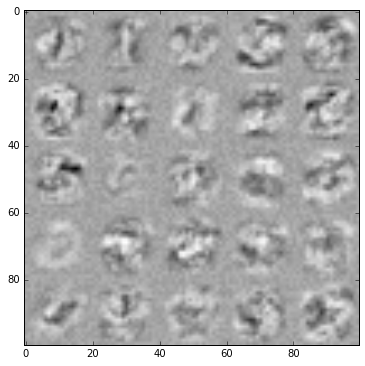

In [26]:
displayHiddenLayer(learned_Thetas[0])